In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

In [0]:
def read_and_create_data(filename):
    df = pd.read_csv(filename)
    df2 = df.join(pd.get_dummies(df.pop('species')))

    np.random.seed(9)
    mask = np.random.rand(len(df2)) < 0.8
    # df2 = df2.sample(frac=1).reset_index(drop=True)
    # print(df2.values)

    df_train = df2[mask]
    df_test = df2[~mask]

    _Y = df_train[df_train.columns[-3:]]
    _X = df_train[df_train.columns[:4]].apply(
        lambda x: (x - x.min())/(x.max() - x.min()))

    y_test = df_test[df_test.columns[-3:]]
    X_test = df_test[df_test.columns[:4]].apply(
        lambda x: (x - x.min())/(x.max() - x.min()))

    return _X, _Y, X_test, y_test

In [0]:
_X, _y,_X_test, _y_test = read_and_create_data('iris.data')


In [0]:
def plot_elements(_X, _y):
    one_type = _X[_y['Iris-setosa'] == 1]
    second_type = _X[_y['Iris-versicolor'] == 1]
    third_type = _X[_y['Iris-virginica'] == 1]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(one_type[one_type.columns[0]],
                one_type[one_type.columns[1]],
                one_type[one_type.columns[2]])
    ax.scatter(second_type[second_type.columns[0]],
                second_type[second_type.columns[1]],
                second_type[second_type.columns[2]])
    ax.scatter(third_type[third_type.columns[0]],
                third_type[third_type.columns[1]],
                third_type[third_type.columns[2]])

    # plt.scatter(second_type[:, 1], second_type[:, 2], s=10)
    plt.show()

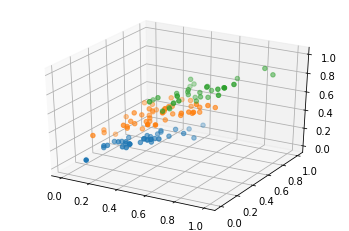

In [89]:
plot_elements(_X, _y)

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def tanh(x):
    return np.tanh(x)


def tanh_deriv(x):
    return 1.0 - np.tanh(x)**2


def sigmoid_derivative(x):
    return x * (1.0 - x)

In [0]:
class HiddenLayer(object):
    def __init__(self, n_input, n_output, function_activation,
                 last_layer=False, W=None, b=None):
        self.n_input = n_input
        self.n_output = n_output
        self.function_activation = function_activation
        self.W = W
        self.b = b
        self.last_layer = last_layer
        if not self.W:
            # Random Weights
            # self.W = np.random.normal(0,1,(n_input, n_output))
            # self.W = normalize(self.W)
            self.W = 2.0*np.random.random((n_input, n_output))-1.0
            self.W /= np.sqrt(n_input)
            # self.W = np.amax(np.random.normal(0,1,(n_input, n_output)), axis=0)
        if not self.b:
            self.b = 2.0*np.random.random((1, n_output))-1.0

        # self.W = np.vstack([self.b, self.W])

        
    def get_activations(self, input, penum=False):
        self.activations = self.function_activation(
            np.dot(input, self.W))
        return self.activations

In [0]:
class MLP(object):
    def __init__(self, n_hidden_layers, n_activations, n_input, n_output):
        self.n_hidden_layers = n_hidden_layers
        self.n_activations = n_activations
        self.n_input = n_input
        self.function_activation = tanh
        self.function_derivative = sigmoid_derivative
        # Add first layer

        self.hidden_layers = [
            HiddenLayer(
                self.n_input,
                self.n_activations,
                self.function_activation
            )
        ]
        # print(self.hidden_layers[0].W.shape)
        for i in range(self.n_hidden_layers-1):
            layer_to_append = HiddenLayer(
                # how n_input use the size of columns of
                # the weights in the last layer
                self.n_activations,
                self.n_activations,
                self.function_activation
            )
            self.hidden_layers.append(layer_to_append)

        # Add last layer
        self.hidden_layers.append(
            HiddenLayer(
                self.n_activations,
                n_output,
                sigmoid,
                last_layer=True
            )
        )

    def round_result(self, predicted):
        predicted[0] = 1 if predicted[0] > 0.5 else 0
        predicted[1] = 1 if predicted[1] > 0.5 else 0
        predicted[2] = 1 if predicted[2] > 0.5 else 0
        return predicted

    def forward(self, input, activations=list(), final_activations=list()):
        # l1 = sigmoid(np.dot(_X.values, mlp.hidden_layers[0].W))
        # # print(l1.shape)
        # # print(mlp.hidden_layers[1].W.shape)
        # l2 = sigmoid(np.dot(l1, mlp.hidden_layers[1].W))

        activations.append(input)
        last_activation = input
        final_activations.append(last_activation)

        for hidden_layer in self.hidden_layers[:-1]:
            last_activation = hidden_layer.get_activations(last_activation)
            activations.append(last_activation)
        #    last_activation = np.append(np.array([1.0]), last_activation)
            final_activations.append(last_activation)

        last_activation = self.hidden_layers[-1].get_activations(
            last_activation)
        activations.append(last_activation)

        return last_activation

    def calculate_cost(self, X, y):
        y_pred_test = self.forward(X)
        first_to_sum = y * np.log(y_pred_test)
        second_to_sum = (1 - y) * np.log(1 - y_pred_test)
        to_sum = first_to_sum + second_to_sum
        return (-(1/(X.shape[0])) * np.sum(to_sum)).mean()

    def sklearn_cost(self, X, y):
        y_pred_test = np.apply_along_axis(self.forward, 1, X)
        return log_loss(y, y_pred_test)

    def get_deltas(self, X, y):
        activations = []
        final_activations = []
        tmp_forward = self.forward(X, activations, final_activations)

        deltas = []
        current_activation = activations[len(activations)-1]
        current_update_activation = activations[len(activations)-2]
        last_delta = (y - current_activation) * self.function_derivative(
            current_activation)
        deltas.append(np.dot(current_update_activation.T, last_delta))
        activations.pop()
        for hidden_layer in reversed(self.hidden_layers[1:]):
            current_activation = activations[len(activations) - 1]
            current_update_activation = activations[len(activations) - 2]
            last_delta = np.dot(
                last_delta, hidden_layer.W.T
            ) * self.function_derivative(current_activation)
            deltas.append(np.dot(current_update_activation.T, last_delta))
            activations.pop()
        deltas.reverse()
        return deltas



In [0]:
def plot_cost_history(iterations, cost_history):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_ylabel('J(Theta)')
    ax.set_xlabel('Iterations')
    _ = ax.plot(range(iterations), cost_history, 'g.')
    plt.show()

In [0]:
mlp = MLP(1,4, tmp_X.shape[0], 3)

In [0]:
learning_rate = 0.01
iterations = 20000

cost_history = np.zeros(iterations)
last_error = mlp.calculate_cost(_X, _y)

In [0]:
for itr in range(iterations):
    _X, _y = shuffle(_X, _y, random_state=1)
    deltas = mlp.get_deltas(_X, _y)
    index = len(mlp.hidden_layers) - 1
    while index >= 0:
        mlp.hidden_layers[index].W += (deltas[index] * learning_rate)
        index -= 1
    last_error = mlp.calculate_cost(_X, _y)
    cost_history[itr] = last_error

In [0]:
asserts = 0
for x, y in zip(_X_test.values, _y_test.values):
    predicted = mlp.forward(x)
    # print(predicted)
    predicted[0] = 1 if predicted[0] > 0.5 else 0
    predicted[1] = 1 if predicted[1] > 0.5 else 0
    predicted[2] = 1 if predicted[2] > 0.5 else 0
    print(predicted, y)
    if (y == predicted).all():
        asserts += 1
print(asserts/_X_test.shape[0])
plot_cost_history(iterations, cost_history)
